In [ ]:
import math, matplotlib.pyplot as plt, operator, torch
from functools import partial

In [ ]:
torch.manual_seed(42)
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)

In [ ]:
n_clusters = 6
n_samples = 250

In [ ]:
centroids = torch.rand(n_clusters, 2)*70-35

In [ ]:
from torch.distributions.multivariate_normal import MultivariateNormal
from torch import tensor

In [ ]:
def sample(m): return MultivariateNormal(m, torch.diag(tensor([5.,5.]))).sample((n_samples,))

In [ ]:
slices = [sample(c) for c in centroids]
data = torch.cat(slices)
data.shape

torch.Size([1500, 2])

In [ ]:
def plot_data(centroids, data, n_samples, ax=None):
    if ax is None: _,ax = plt.subplots()
    for i, centroid in enumerate(centroids):
        samples = data[i*n_samples:(i+1)*n_samples]
        ax.scatter(samples[:,0], samples[:,1], s=1)
        ax.plot(*centroid, markersize=10, marker="x", color='k', mew=5)
        ax.plot(*centroid, markersize=5, marker="x", color='m', mew=2)

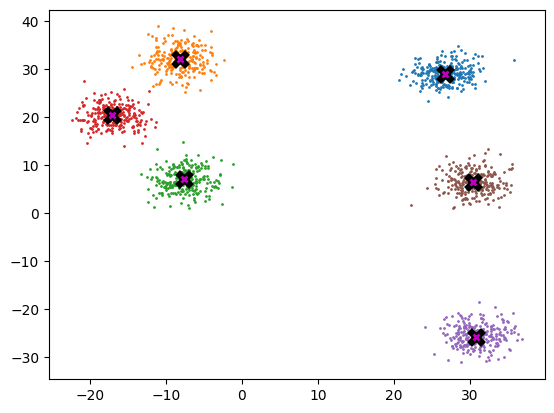

In [ ]:
plot_data(centroids, data, n_samples)

In [ ]:
midp = data.mean(0)
midp

tensor([ 9.222, 11.604])

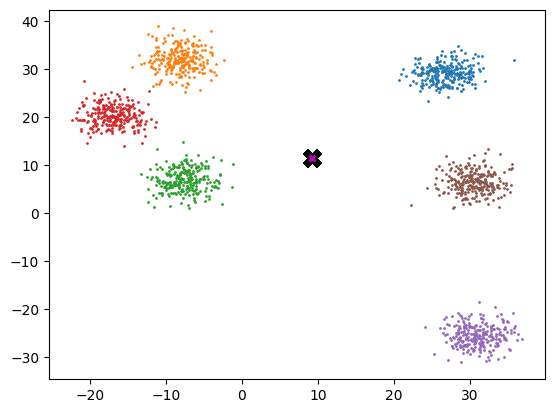

In [ ]:
plot_data([midp]*6, data, n_samples)

In [ ]:
def gaussian(d, bw): return torch.exp(-0.5*((d/bw))**2) / (bw*math.sqrt(2*math.pi))

In [ ]:
def plot_function(f):
    x = torch.linspace(0,10,100)
    plt.plot(f(x))

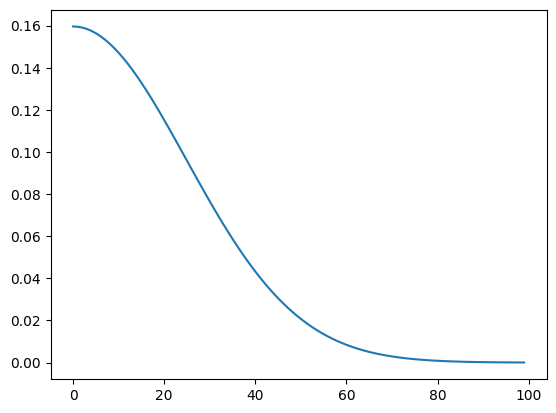

In [ ]:
plot_function(partial(gaussian,bw=2.5))

In [ ]:
X = data.clone()
x = X[0]
x.shape

torch.Size([2])

In [ ]:
((x-X)**2).sum(1).sqrt()

tensor([ 0.000,  3.899,  4.834,  ..., 17.628, 22.610, 21.617])

In [ ]:
dist = ((x-X)**2).sum(1).sqrt()

In [ ]:
weights = gaussian(dist, 2.5)
weights.shape

torch.Size([1500])

In [ ]:
weights.shape, X.shape

(torch.Size([1500]), torch.Size([1500, 2]))

In [ ]:
(weights[:,None] * X).sum(0)

tensor([406.866, 431.454])

In [ ]:
weights.sum()

tensor(15.388)

In [ ]:
((weights[:,None] * X).sum(0))/weights.sum()

tensor([26.440, 28.038])

In [ ]:
def one_update(X):
    for i, x in enumerate(X):
        dist = ((x-X)**2).sum(1).sqrt()
        weights = gaussian(dist, 2.5)
        X[i] = ((weights[:,None] * X).sum(0))/weights.sum()

In [ ]:
def meanshift(data):
    X = data.clone()
    for i in range(5): one_update(X)
    return X

In [ ]:
%time X=meanshift(data)

CPU times: user 1.45 s, sys: 0 ns, total: 1.45 s
Wall time: 1.45 s


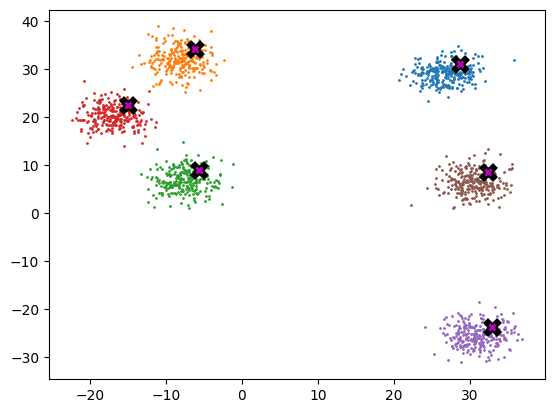

In [ ]:
plot_data(centroids+2, data, n_samples)

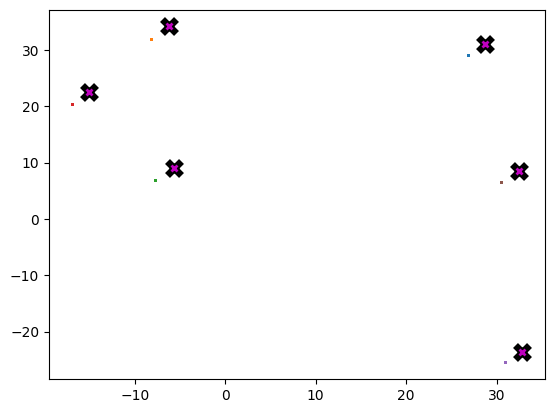

In [ ]:
plot_data(centroids+2, X, n_samples)

In [ ]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [ ]:
def do_one(d):
    if d: one_update(X)
    ax.clear()
    plot_data(centroids+2, X, n_samples, ax=ax)

In [ ]:
X = data.clone()
fig,ax = plt.subplots()
ani = FuncAnimation(fig, do_one, frames=5, interval=500, repeat=False)
plt.close()
HTML(ani.to_jshtml())

## GPU batched algorithm

In [ ]:
bs = 5
X = data.clone()
x = X[:bs]
X.shape, x.shape

(torch.Size([1500, 2]), torch.Size([5, 2]))

In [ ]:
X[None].shape, x[:,None].shape

(torch.Size([1, 1500, 2]), torch.Size([5, 1, 2]))

In [ ]:
(X[None]-x[:,None]).shape

torch.Size([5, 1500, 2])

In [ ]:
((X[None]-x[:,None])**2).sum(2).sqrt().shape

torch.Size([5, 1500])

In [ ]:
def dist_b(a,b):
    return ((a[None]-b[:,None])**2).sum(2).sqrt()

In [ ]:
dist_b(X,x)

tensor([[ 0.000,  3.899,  4.834,  ..., 17.628, 22.610, 21.617],
        [ 3.899,  0.000,  4.978,  ..., 21.499, 26.508, 25.500],
        [ 4.834,  4.978,  0.000,  ..., 19.373, 24.757, 23.396],
        [ 3.726,  0.185,  4.969,  ..., 21.335, 26.336, 25.333],
        [ 6.273,  5.547,  1.615,  ..., 20.775, 26.201, 24.785]])

In [ ]:
weights = gaussian(dist_b(X,x), 2.5)
weights.shape

torch.Size([5, 1500])

In [ ]:
X.shape, weights.shape

(torch.Size([1500, 2]), torch.Size([5, 1500]))

In [ ]:
(weights @ X).shape

torch.Size([5, 2])

In [ ]:
div = weights.sum(1, keepdim=True); div.shape

torch.Size([5, 1])

In [ ]:
(weights@X/div).shape

torch.Size([5, 2])

In [ ]:
def meanshift(data, bs=500):
    X = data.clone()
    n = len(data)
    for it in range(5):
        for i in range(0,n,bs):
            s = slice(i, min(i+bs, n))
            dists = dist_b(X, X[s])
            weights = gaussian(dists, 2.5)
            div = weights.sum(1, keepdim=True)
            X[s] = (weights @ X)/div
    return X

In [ ]:
data = data.cuda()

In [ ]:
X = meanshift(data).cpu()

In [ ]:
%time _=meanshift(data, bs=5000).cpu()

CPU times: user 8.6 ms, sys: 193 µs, total: 8.79 ms
Wall time: 7.04 ms


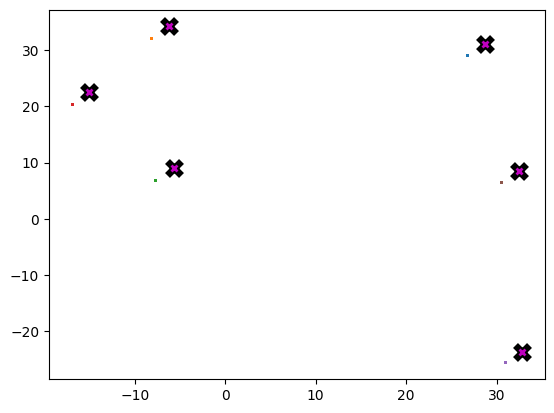

In [ ]:
plot_data(centroids+2, X, n_samples)